# Clustering de texto usando técnicas de PNL

* Este notebook é uma adaptação do trabalho divulgado por Daniel Afrimi em "Text Clustering using NLP techniques" disponível em : https://medium.com/@danielafrimi/text-clustering-using-nlp-techniques-c2e6b08b6e95
* O objetivo é explorar e implementar as duas técnicas de melhor desempenho observadas por Afrimi.
* Este notebook se diferencia ao oferecer resumo em tópicos dos conceitos abordados e explicações do código utilizado, além de fornecer informações adicionais e links relevantes que enriquecem a compreensão e a pesquisa sobre clusterização de textos.

## Clusterização de texto 

* Processo de agrupar documentos semelhantes com base em seu conteúdo.
* Processo de aprendizado não supervisionado usado para agrupar documentos semelhantes em categorias ou clusters(https://www.linkedin.com/pulse/conhe%C3%A7a-os-principais-m%C3%A9todos-de-agrupamento-texto-gilson-castro/).
* Objetivos: identificar padrões e tendências que de outra forma seriam difíceis de discernir.
* Se difere da classificação de texto pois na classificação as categorias já são conhecidas. A clusterização categoriza textos em grupos que mais façam sentido. (https://lamfo-unb.github.io/2019/09/02/cluster_texto/)

##### Objetivo do código: Usar **técnicas de incorporação** de texto e aplicar **clusterização com o algoritmo K-Means** para agrupar em 3 categorias os textos do conjunto de dados **20newsgroups**.

## Importações

In [1]:
import re
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
from sentence_transformers import SentenceTransformer
from gensim.models import KeyedVectors
from sklearn.cluster import KMeans 
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score
from sklearn.decomposition import PCA
import torch
from transformers import BertTokenizer, BertModel
import seaborn as sns
import matplotlib.pyplot as plt


## Database - 20newsgroups

* Este conjunto de dados é uma coleção de documentos de grupos de notícias. A coleção de 20 grupos de notícias tornou-se um conjunto de dados popular para experimentos em aplicações de texto de técnicas de aprendizado de máquina, como classificação e agrupamento de texto.
* 20newsgroups com 3 categorias.
* https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html


In [4]:
# Download NLTK resources (if not already downloaded)
nltk.download('punkt') # usado para dividir texto em tokens
nltk.download('stopwords')

categories = [
    'comp.os.ms-windows.misc',
    'rec.sport.hockey',
    'soc.religion.christian',
]

dataset = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, remove=('headers', 'footers', 'quotes')) #retorna uma lista de textos brutos 
"""Apenas o conjunto de treinamento com as 3 categorias definidas anteriormente.
    shuffle=True indica que queremos embaralhar os dados.
    O parâmetro remove=('headers', 'footers', 'quotes') indica que queremos remover cabeçalhos, rodapés e citações dos textos."""

data = {'text': dataset.data, 'target': dataset.target} #cria dicionário com o texto dos documentos e com os rótulos
df = pd.DataFrame(data) # converte o dicionário pra dataframe
df

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\syann\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\syann\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,target
0,\n >>So good that there isn't any diff wheth...,0
1,\n\nWell I don't see any smileys here. I am t...,1
2,\n\nI haven't heard any news about ASN carryin...,1
3,"well, the subject says just about all I intend...",0
4,\n Just a quick question. If Mary was Immacu...,2
...,...,...
1785,I find it interesting that cls never answered ...,2
1786,\nDon't you Americans study history...the Fren...,1
1787,\n\tJesus was born a Jew. We have biblical ac...,2
1788,"09 Apr 93, Jill Anne Daley writes to All:\n\n ...",2


## Pré-processamento 
* Preparar os dados de texto para análise posterior, removendo informações irrelevantes e transformando o texto em uma forma adequada para as etapas subsequentes, como vetorização e modelagem

* Eliminará links, caracteres especiais, espaços em branco e palavras irrelevantes.

In [5]:
def preprocess_text(text: str) -> str:
    # remove links
    text = re.sub(r"http\S+", "", text)
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)
    
    # remove stopwords
    tokens = nltk.word_tokenize(text)
    tokens = [w for w in tokens if not w.lower() in nltk.corpus.stopwords.words("english")]
    text = " ".join(tokens)
    text = text.lower().strip()
    
    return text

df['text_cleaned'] = df['text'].apply(lambda text: preprocess_text(text))
df = df[df['text_cleaned'] != '']

In [6]:
df

,text,target,text_cleaned
0,\n >>So good that there isn't any diff wheth...,0,good diff whether atmanager turned worth run a...
1,\n\nWell I don't see any smileys here. I am t...,1,well see smileys trying figure poster dog word...
2,\n\nI haven't heard any news about ASN carryin...,1,heard news asn carrying games local cable stat...
3,"well, the subject says just about all I intend...",0,well subject says intended ask way insert colo...
4,\n Just a quick question. If Mary was Immacu...,2,quick question mary immaculately concieved cou...
...,...,...,...
1785,I find it interesting that cls never answered ...,2,find interesting cls never answered questions ...
1786,\nDon't you Americans study history...the Fren...,1,americans study history french settled north a...
1787,\n\tJesus was born a Jew. We have biblical ac...,2,jesus born jew biblical accounts mother ancest...
1788,"09 Apr 93, Jill Anne Daley writes to All:\n\n ...",2,apr jill anne daley writes jad exactly definit...


## Vetorização TF-IDF

* term frequency-inverse document frequency
* Calcula a importância das palavras em uma frase levando em consideração a frequência com que aparecem na frase e o quão raras são em todo o corpus de frases.
* Técnica de processamento de linguagem natural usada para converter texto em representações numéricas.

* TF (Term Frequency):
    * Mede a frequência de uma palavra em um documento específico.
    * É calculado como o número de vezes que uma palavra aparece em um documento dividido pelo número total de palavras no documento.
* IDF (Inverse Document Frequency):
    * Mede a raridade de uma palavra em um corpus de documentos.
    * É calculado como o logaritmo do número total de documentos dividido pelo número de documentos que contêm a palavra.
* Combinação:
    * O TF-IDF combina essas duas medidas para atribuir pesos às palavras em um documento, onde palavras frequentes em um documento, mas raras no corpus, recebem pesos mais altos.    

->  ajuda a identificar palavras-chave importantes em um documento ou corpus, destacando termos que são distintivos e informativos

In [16]:
# TF-IDF Vectorization
"""vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95):
Cria uma instância do TfidfVectorizer, que é uma classe do scikit-learn usada para vetorização TF-IDF.
sublinear_tf=True: Aplica a função de transformação sublinear TF, que pode melhorar o desempenho.
min_df=5: Ignora termos que têm uma frequência de documento (DF) menor do que o valor especificado (neste caso, 5 documentos).
max_df=0.95: Ignora termos que têm uma frequência de documento (DF) maior do que a porcentagem especificada do corpus (neste caso, 95%)."""

vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95) # 
X = vectorizer.fit_transform(df['text_cleaned']).toarray() # aplica a vetorização nos textos e guarda o resultado como array na variável X
# X contém os vetores TF-IDF para cada documento no corpus.

## Abordagem de incorporação - Sentence Transformer

* Abordagem de incorporação: Incorporações são representações numéricas de objetos do mundo real que os sistemas de machine learning (ML) e inteligência artificial (IA) usam para entender domínios complexos do conhecimento, como os humanos. https://aws.amazon.com/pt/what-is/embeddings-in-machine-learning/
    * resultam nos embeddings https://www.elastic.co/pt/what-is/word-embedding 
* Sentense trasformer (https://sbert.net/):
    * Uma estrutura Python para incorporações de frases, textos e imagens de última geração.
    * Usa modelos de aprendizado profundo que podem *codificar sentenças de linguagem natural em representações vetoriais de alta dimensão*
    * São  modelos treinados usando uma abordagem de pré-treinamento e ajuste fino e alcançaram desempenho de última geração em diversas tarefas de processamento de linguagem natural.
    * Modelo usado: https://huggingface.co/sentence-transformers/paraphrase-MiniLM-L6-v2
        * Mapeia frases e parágrafos para um espaço vetorial denso de 384 dimensões e pode ser usado para tarefas como agrupamento ou pesquisa semântica.

In [9]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2') #instancia/inicializa o modelo
df['encode_transformers'] = df['text_cleaned'].apply(lambda text: model.encode(text, convert_to_numpy=True).flatten())  # aplica o modelo no texto convertendo cada um em sua representação vetorial usando o modelo Sentence Transformer.
"""O método flatten() é usado para garantir que os embeddings resultantes tenham a mesma forma, independentemente do tamanho do texto.
 Isso é útil para garantir que os embeddings tenham dimensões compatíveis para empilhamento posterior."""

X_transformers = np.vstack(df['encode_transformers']) #Empilha os embeddings resultantes em uma única matriz. Cada linha da matriz corresponderá aos embeddings de um texto individual.
#O np.vstack() é usado para empilhar os embeddings verticalmente, ou seja, ao longo do eixo 0 da matriz.
#O resultado é uma matriz X_transformers que contém os embeddings de todos os textos do DataFrame df.

C:\Users\syann\AppData\Local\Temp\ipykernel_2856\2293716587.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['encode_transformers'] = df['text_cleaned'].apply(lambda text: model.encode(text, convert_to_numpy=True).flatten())  # aplica o modelo no texto convertendo cada um em sua representação vetorial usando o modelo Sentence Transformer.


### Análise de Componentes Principais (PCA).
* Técnica estatística usada principalmente para redução de dimensionalidade em dados numéricos.
* Usada para reduzir a dimensionalidade das representações incorporadas para visualização dos resultados.
* Simplifica o conjuntos de dados com muitas variáveis ​​em um conjunto menor de variáveis, mantendo o máximo de informações possível. 
* O objetivo do PCA é encontrar novas variáveis, chamadas componentes principais, que são combinações lineares das variáveis originais.

In [10]:
def dimension_reduction(embedding, method):
    """
    Reduz a dimensionalidade dos embeddings usando PCA e adiciona as componentes reduzidas ao DataFrame.

    Parâmetros:
        embedding (numpy.array): Embeddings de entrada para os quais a redução de dimensionalidade será aplicada.
        method (str): Nome do método de embedding usado, usado para rotular as novas colunas no DataFrame.

    Saída:
        None. Os resultados da redução de dimensionalidade são adicionados ao DataFrame df como novas colunas.
    """
    pca = PCA(n_components=2, random_state=42)
    pca_vecs = pca.fit_transform(embedding)
    x0 = pca_vecs[:, 0]
    x1 = pca_vecs[:, 1]
    
    df[f'x0_{method}'] = x0 
    df[f'x1_{method}'] = x1

### Função pra plotagem do gráfico 

In [11]:
def plot_pca(x0_name, x1_name, cluster_name, method):
    plt.figure(figsize=(12, 7))
    plt.title(f"TF-IDF + KMeans 20newsgroup clustering with {method}", fontdict={"fontsize": 18})
    plt.xlabel("X0", fontdict={"fontsize": 16})
    plt.ylabel("X1", fontdict={"fontsize": 16})
    sns.scatterplot(data=df, x=x0_name, y=x1_name, hue=cluster_name, palette="viridis")
    plt.show()
    

### Métricas de avaliação

1. ARI - Adjusted Rand Index | : 
    * Mede a *similaridade* entre os clusters previstos e os rótulos de verdade, levando em consideração a concordância aleatória.
    * Varia de -1 a 1, onde 1 indica concordância perfeita e 0 indica agrupamento aleatório.
    * Não é normalizado e não possui um intervalo fixo, o que dificulta a interpretação direta. No entanto, é ajustado para corrigir a aleatoriedade esperada em caso de concordância aleatória.
2. NMI - Normalized Mutual Information
    * Mede a *informação mútua* entre os clusters previstos e os rótulos de verdade, normalizada pela entropia dos clusters e rótulos.
    * Verifica o quão bem os clusters encontrados representam a verdadeira estrutura dos dados, levando em consideração a incerteza nos clusters e nos rótulos verdadeiros.
    * Mede a quantidade de informação mútua entre os clusters previstos por um algoritmo de clustering e os rótulos verdadeiros dos dados.
    * É normalizado pela entropia dos clusters e rótulos verdadeiros, garantindo que varie de 0 a 1 e facilitando a interpretação.
    * Varia de 0 a 1, onde 1 indica concordância perfeita.

OBS: O ARI é menos sensível à aleatoriedade do que o NMI, o que significa que ele tende a fornecer resultados mais estáveis, especialmente para conjuntos de dados pequenos ou clusters desbalanceados.
O NMI pode ser mais sensível à aleatoriedade, especialmente para conjuntos de dados pequenos ou clusters de tamanho desigual, porque leva em consideração a entropia dos clusters e rótulos verdadeiros.

3. FMI - Fowlkes-Mallows Index 

    * Mede a média geométrica da precisão e recuperação(Recall) dos clusters previstos em relação aos rótulos de verdade.
    * Varia de 0 a 1, onde 1 indica concordância perfeita.
    * média geométrica da precisão e recuperação(Recall): Medida combinada que avalia a qualidade dos clusters encontrados por um algoritmo de clustering em comparação com os rótulos verdadeiros dos dados.

        * Precisão:
            * proporção de verdadeiros positivos (TP) sobre todos os elementos previstos como pertencentes a uma determinado cluster
            * Mede a proporção de elementos corretamente atribuídos a um cluster em relação ao total de elementos atribuídos a esse cluster.
            * Verdadeiros positivos(classificação correta)/ verdadeiros positivos + falsos positivos(classificação equivocada)
        * Recall: 
            * Medida de quão bem os clusters previstos capturam todos os elementos de uma classe ou cluster verdadeiro.
            * Proporção de verdadeiros positivos (TP) sobre todos os elementos que realmente pertencem a uma determinada classe ou cluster.
            * TP / (TP + FN), onde TP são os verdadeiros positivos (elementos corretamente atribuídos ao cluster) e FN são os falsos negativos (elementos que deveriam estar no cluster, mas não foram atribuídos a ele).



In [18]:
def eval_cluster(embedding):
    """
    Avalia o desempenho do clustering usando os embeddings fornecidos.

    Parâmetros:
        embedding (numpy.array): Embeddings dos dados para os quais o clustering foi aplicado.

    Saída:
        None. Imprime as pontuações das métricas de avaliação do clustering.
    """
    y_pred = KMeans.fit_predict(embedding)
    
    # Evaluate the performance using ARI, NMI, and FMI
    ari = adjusted_rand_score(df["target"], y_pred)
    nmi = normalized_mutual_info_score(df["target"], y_pred)
    fmi = fowlkes_mallows_score(df["target"], y_pred)

    # Print Metrics scores
    print("Adjusted Rand Index (ARI): {:.5f}".format(ari))
    print("Normalized Mutual Information (NMI): {:.5f}".format(nmi))
    print("Fowlkes-Mallows Index (FMI): {:.5f}".format(fmi))

### Clusterização - K-means

* Objetivo: Agrupar os textos por similaridade usando algoritmo de agrupamento k-means.
* K-means: Particiona os dados em k clusters com base em sua similaridade.
* Será usado k = 3 pq são 3 categorias possíveis.
* Chamamos as classes de centróides e elas representam o centro de cada cluster.
* Identifica k classes ou centróides que representam os diferentes agrupamentos de documentos semelhantes. 

#### Agrupamento K-means

* Atribui aleatoriamente cada ponto de dados a um dos K ​​centróides.
* Reatribui iterativamente cada ponto de dados ao centróide mais próximo dele e atualiza os centróides com base nas novas atribuições. 
* Repete as reatribuições até que os centróides não mudem mais ou até que um número máximo de iterações seja alcançado.


c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\syann\AppData\Local\Temp\ipykernel_2856\3629961249.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[clusters_result_name] = clusters
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index (ARI): 0.74646
Normalized Mutual Information (NMI): 0.71113
Fowlkes-Mallows Index (FMI): 0.83186


C:\Users\syann\AppData\Local\Temp\ipykernel_2856\1438514964.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'x0_{method}'] = x0
C:\Users\syann\AppData\Local\Temp\ipykernel_2856\1438514964.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'x1_{method}'] = x1


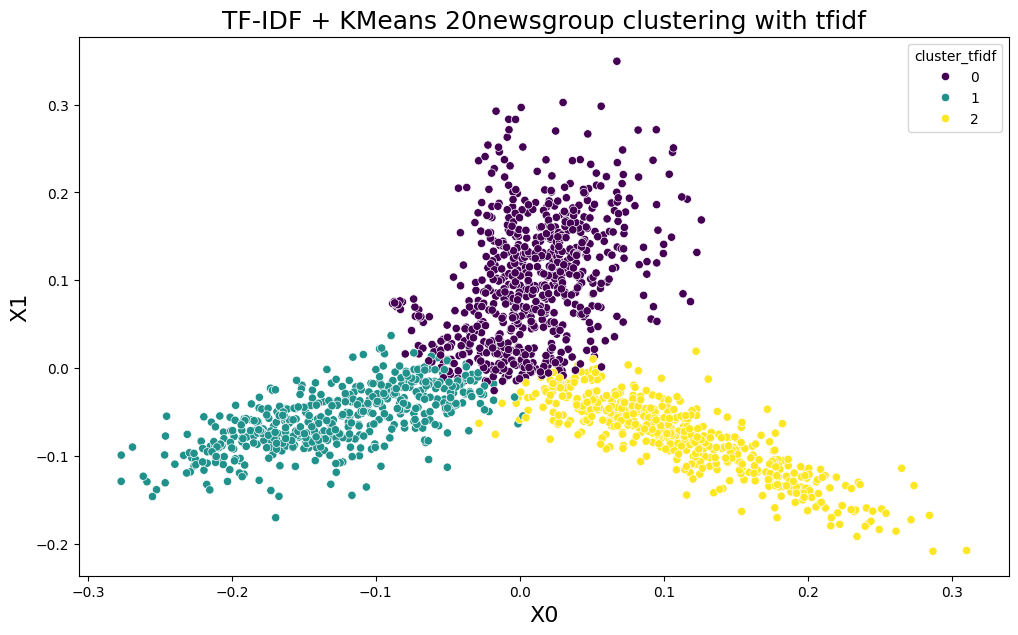

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\syann\AppData\Local\Temp\ipykernel_2856\3629961249.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[clusters_result_name] = clusters
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index (ARI): 0.87725
Normalized Mutual Information (NMI): 0.82187
Fowlkes-Mallows Index (FMI): 0.91815


C:\Users\syann\AppData\Local\Temp\ipykernel_2856\1438514964.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'x0_{method}'] = x0
C:\Users\syann\AppData\Local\Temp\ipykernel_2856\1438514964.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'x1_{method}'] = x1


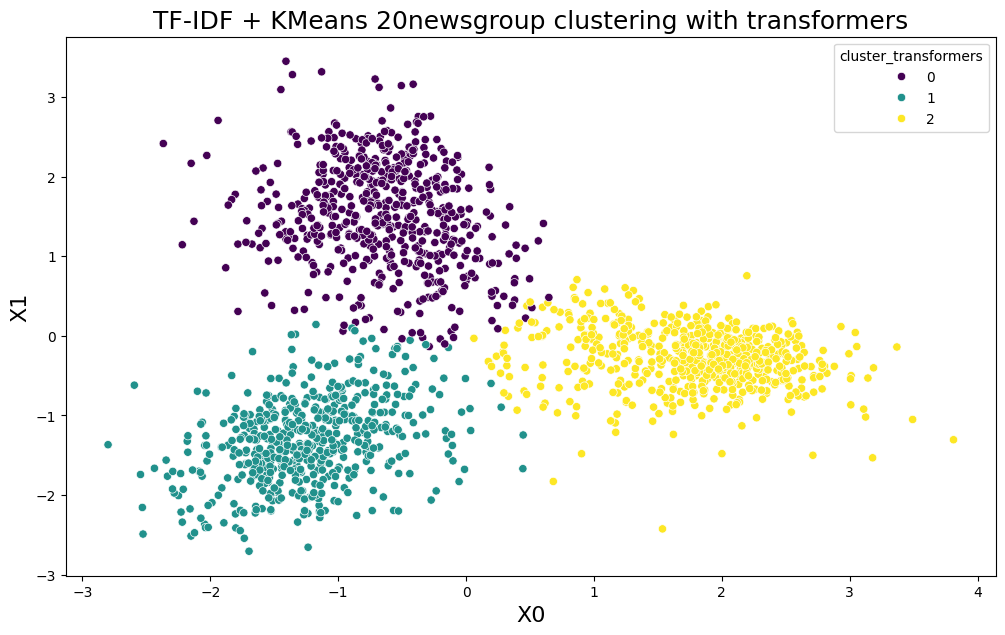

In [19]:
for embedding_and_method in [(X, 'tfidf'),(X_transformers, 'transformers')]:
    embedding, method = embedding_and_method[0], embedding_and_method[1]
    
    kmeans = KMeans(n_clusters=3, random_state=42)
    kmeans.fit(embedding)
    clusters = kmeans.labels_
    clusters_result_name = f'cluster_{method}'
    df[clusters_result_name] = clusters
    
    eval_cluster(embedding)
    dimension_reduction(embedding, method)
    plot_pca(f'x0_{method}', f'x1_{method}', cluster_name=clusters_result_name, method=method)


### obs pessoal: Tentativa de combinar o TF-IDF com o Sentence Transformer -> não alterou o resultado

In [20]:
# Concatenate TF-IDF and Sentence Transformer embeddings
X_combined = np.concatenate((X, X_transformers), axis=1)

# Apply clustering algorithm (e.g., K-Means) to combined embeddings
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_combined)

# Evaluate clustering performance
ari = adjusted_rand_score(df["target"], clusters)
nmi = normalized_mutual_info_score(df["target"], clusters)
fmi = fowlkes_mallows_score(df["target"], clusters)

print("Adjusted Rand Index (ARI): {:.5f}".format(ari))
print("Normalized Mutual Information (NMI): {:.5f}".format(nmi))
print("Fowlkes-Mallows Index (FMI): {:.5f}".format(fmi))

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index (ARI): 0.87725
Normalized Mutual Information (NMI): 0.82187
Fowlkes-Mallows Index (FMI): 0.91815
